<a href="https://colab.research.google.com/github/mevalle/MPCL-CCP/blob/main/Experiments_with_the_Credit_Card_Fraud_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import basic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.under_sampling import RandomUnderSampler

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import the MPCL module and install other necessary libraries!

In [2]:
# Download MPCL.py from the GitHub repository
!wget -O MPCL.py https://raw.githubusercontent.com/mevalle/MPCL-CCP/master/MPCL.py
print('MPCL.py downloaded successfully!')

!pip install dccp

--2026-02-12 21:37:47--  https://raw.githubusercontent.com/mevalle/MPCL-CCP/master/MPCL.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19629 (19K) [text/plain]
Saving to: ‘MPCL.py’

MPCL.py             100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2026-02-12 21:37:47 (28.4 MB/s) - ‘MPCL.py’ saved [19629/19629]

MPCL.py downloaded successfully!


In [3]:
from MPCL import MPCL_CCP

# Import the dataset and pre-process the dataset

## Import the dataset

1. Go to your Kaggle account settings.
2. In the 'API' section, click 'Create New API Token' to download kaggle.json.
3. Upload this kaggle.json file to your Colab environment (e.g., in the 'Files' tab).
4. Move the kaggle.json file to the correct directory: /root/.config/kaggle/.

Once you've done this, please run the cell.

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

# 2. Initialize and Authenticate
api = KaggleApi()
api.authenticate()

# 3. Download Dataset
# Format: 'owner/dataset-name' (found in the URL)
dataset = 'mlg-ulb/creditcardfraud'
api.dataset_download_files(dataset, path='DataSets/Kaggle/data', unzip=True)

print("Download complete!")

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
Download complete!


In [5]:
try:
    df = pd.read_csv('DataSets/Kaggle/data/creditcard.csv')
    print(f"Dataset loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: The file 'creditcard.csv' was not found.")

Dataset loaded. Shape: (284807, 31)


In [6]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Preprocess the data

In [7]:
scaler_amount = RobustScaler()
scaler_time = RobustScaler()

df['scaled_amount'] = scaler_amount.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler_time.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

print("Preprocessing complete. 'Time' and 'Amount' have been scaled.")

Preprocessing complete. 'Time' and 'Amount' have been scaled.


In [8]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.296653,1.034951
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,0.038986,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,0.641096,1.034975
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.167680,1.034975


## Train and test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

fraud_count_train = sum(y_train)
print(f"Training set shape: {X_train.shape}")
print(f"Fraud cases in training set: {fraud_count_train}")

Training set shape: (227845, 30)
Fraud cases in training set: 394


## Handling imbalance with RandomUndersampling

In [10]:
print(f"Fraud cases in the training dataset: {100*sum(y_train)/X_train.shape[0]:.2f}%")

print("Applying random undersampling to the training set...")

# Use random undersampling to reduce the majority class.
X_train_less, y_train_less = RandomUnderSampler(sampling_strategy=0.05,random_state=42).fit_resample(X_train, y_train)
# X_train_less, y_train_less = SMOTE().fit_resample(X_train_less, y_train_less)

print(f"Resampled Training shape: {X_train_less.shape}")
print(f"Fraud cases after undersampling: {sum(y_train_less):d}, representing {100*sum(y_train_less)/X_train_less.shape[0]:.2f}% of the dataset")

Fraud cases in the training dataset: 0.17%
Applying random undersampling to the training set...
Resampled Training shape: (8274, 30)
Fraud cases after undersampling: 394, representing 4.76% of the dataset


# MLP Classifier


Final Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.32      0.89      0.47        98

    accuracy                           1.00     56962
   macro avg       0.66      0.94      0.74     56962
weighted avg       1.00      1.00      1.00     56962



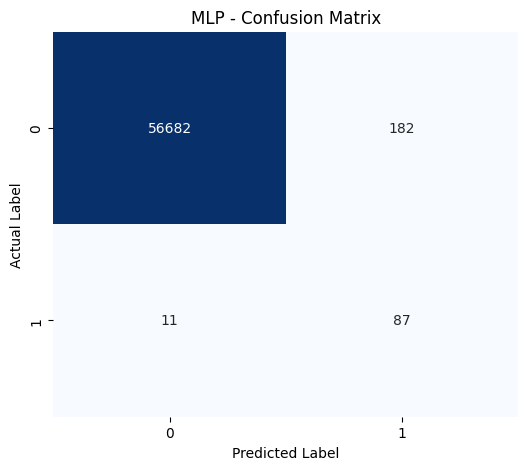

In [11]:
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_less,y_train_less)

y_pred = mlp.predict(X_test)
cm_mlp = confusion_matrix(y_test, y_pred)


print("\nFinal Evaluation")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('MLP - Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# SVC Classifier


Final Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.85      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.92      0.88     56962
weighted avg       1.00      1.00      1.00     56962



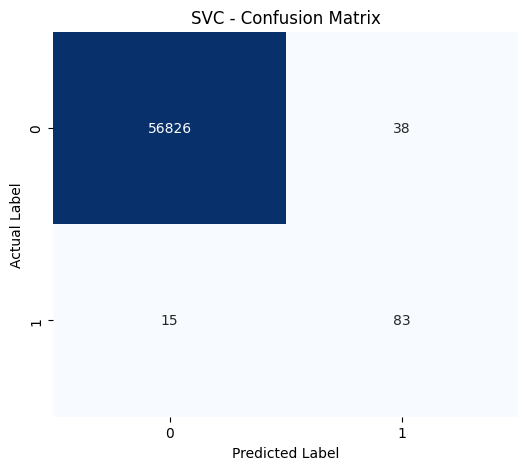

In [12]:
svc = SVC(random_state=42,probability=True)
svc.fit(X_train_less,y_train_less)

y_pred = svc.predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred)

print("\nFinal Evaluation")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVC - Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Random Forest Classifier


Final Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.68      0.88      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.94      0.88     56962
weighted avg       1.00      1.00      1.00     56962



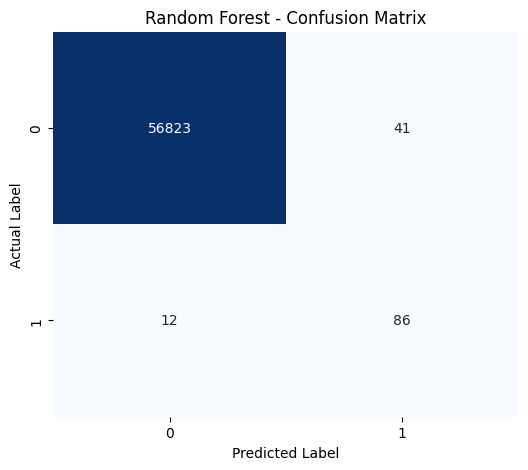

In [13]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_less,y_train_less)

y_pred = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred)

print("\nFinal Evaluation")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# MPCL-CCP Classifier

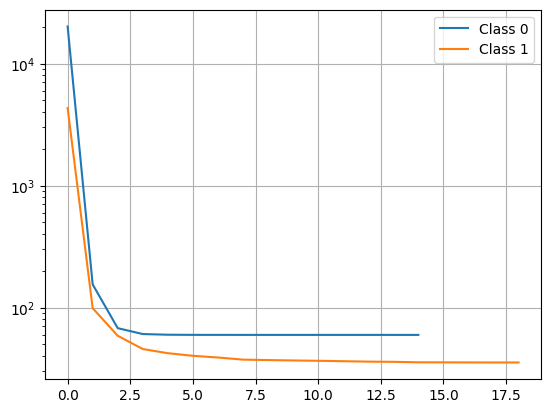

In [14]:
mpcl = MPCL_CCP(K=40, gamma=1.e-2, verbose=0, random_state=42)
loss_values = mpcl.fit(X_train_less,y_train_less)

for i in range(len(loss_values)):
    plt.semilogy(loss_values[i],label=f'Class {i}')
plt.grid()
plt.legend()


Final Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.55      0.90      0.68        98

    accuracy                           1.00     56962
   macro avg       0.77      0.95      0.84     56962
weighted avg       1.00      1.00      1.00     56962



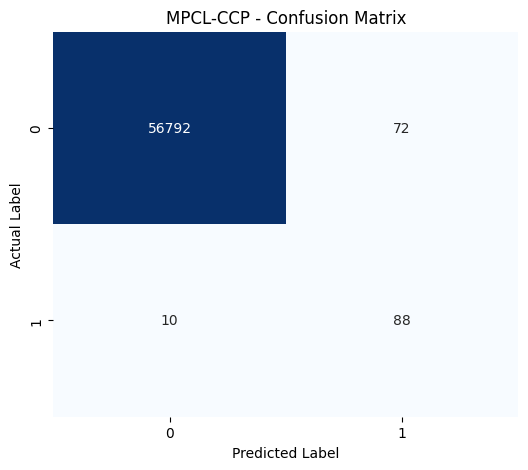

In [15]:
y_pred = mpcl.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("\nFinal Evaluation")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('MPCL-CCP - Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()